              ip                 timestamp  \
0   54.36.149.41 2019-01-22 03:56:14+03:30   
1    31.56.96.51 2019-01-22 03:56:16+03:30   
2    31.56.96.51 2019-01-22 03:56:16+03:30   
3  40.77.167.129 2019-01-22 03:56:17+03:30   
4    91.99.72.15 2019-01-22 03:56:17+03:30   

                                             request status   size  \
0  GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...    200  30577   
1     GET /image/60844/productModel/200x200 HTTP/1.1    200   5667   
2     GET /image/61474/productModel/200x200 HTTP/1.1    200   5379   
3     GET /image/14925/productModel/100x100 HTTP/1.1    200   1696   
4  GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...    200  41483   

                              referrer  \
0                                    -   
1  https://www.zanbil.ir/m/filter/b113   
2  https://www.zanbil.ir/m/filter/b113   
3                                    -   
4                                    -   

                                          user_ag

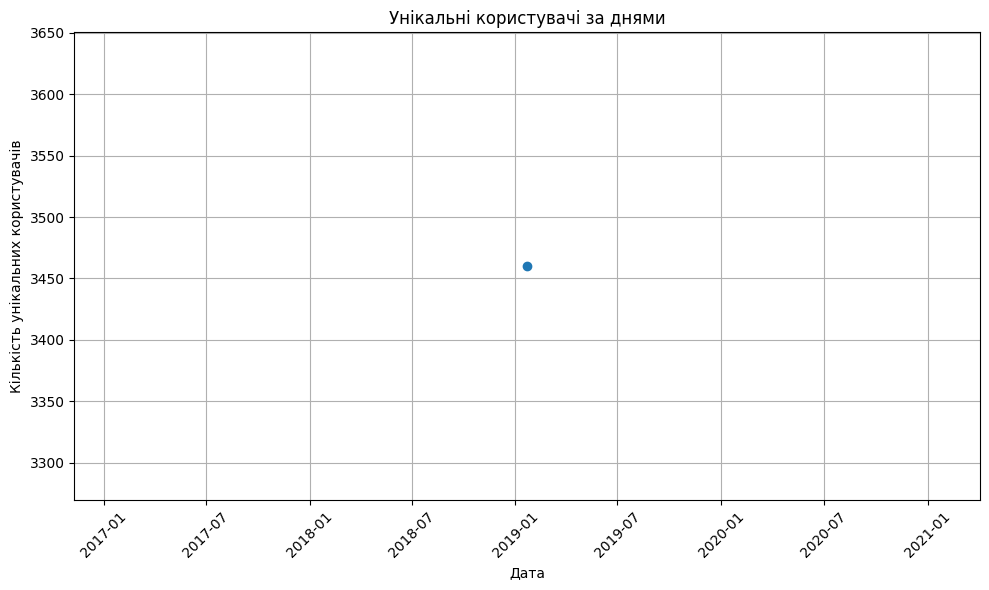

In [35]:
import re
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Функція для парсингу рядка логів
def parse_log_entry(entry):
    log_entry_pattern = re.compile(
        r'(?P<ip>\d+\.\d+\.\d+\.\d+) - - \[(?P<timestamp>[^\]]+)\] "(?P<request>[^"]+)" (?P<status>\d+) (?P<size>\d+) "(?P<referrer>[^"]*)" "(?P<user_agent>[^"]+)"'
    )
    match = log_entry_pattern.match(entry)
    if match:
        data = match.groupdict()
        data['timestamp'] = datetime.strptime(data['timestamp'], '%d/%b/%Y:%H:%M:%S %z')
        return data
    return None

file_path = 'access-2.log'

# Читання файлу по частинах і парсинг логів
parsed_entries = []
chunk_size = 10000  # Кількість рядків для обробки за раз

with open(file_path, 'r') as file:
    chunk = []
    for line in file:
        parsed_entry = parse_log_entry(line)
        if parsed_entry:
            chunk.append(parsed_entry)
        if len(chunk) >= chunk_size:
            parsed_entries.extend(chunk)
            chunk = []
    if chunk:
        parsed_entries.extend(chunk)

# Створення DataFrame зі спарсених даних
df = pd.DataFrame(parsed_entries)

# Витягнення дати з тимчасової мітки
df['date'] = df['timestamp'].dt.date

# Підрахунок унікальних користувачів за днями
user_counts = df.groupby('date')['ip'].nunique().reset_index(name='unique_users')

print(df.head())

# Відображення таблиці
print(user_counts)

# Побудова графіка
plt.figure(figsize=(10, 6))
plt.plot(user_counts['date'], user_counts['unique_users'], marker='o')
plt.title('Унікальні користувачі за днями')
plt.xlabel('Дата')
plt.ylabel('Кількість унікальних користувачів')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


                                             user_agent  count  \
0     Mozilla/5.0 (compatible; bingbot/2.0; +http://...   8892   
1     Mozilla/5.0 (compatible; Googlebot/2.1; +http:...   7388   
2     Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...   6743   
3     Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:6...   2747   
4     Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...   2568   
...                                                 ...    ...   
1425  Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_2 like...      1   
1426  Dalvik/2.1.0 (Linux; U; Android 6.0.1; SM-N915...      1   
1427  Mozilla/5.0 (compatible; Nimbostratus-Bot/v1.3...      1   
1428  Mozilla/5.0 (Linux; Android 7.0; LG-M250) Appl...      1   
1429  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...      1   

                       user_agent_short  
0     Mozilla/5.0 (compatible; bingb...  
1     Mozilla/5.0 (compatible; Googl...  
2     Mozilla/5.0 (Linux; Android 6....  
3     Mozilla/5.0 (Windows NT 10.0; ...

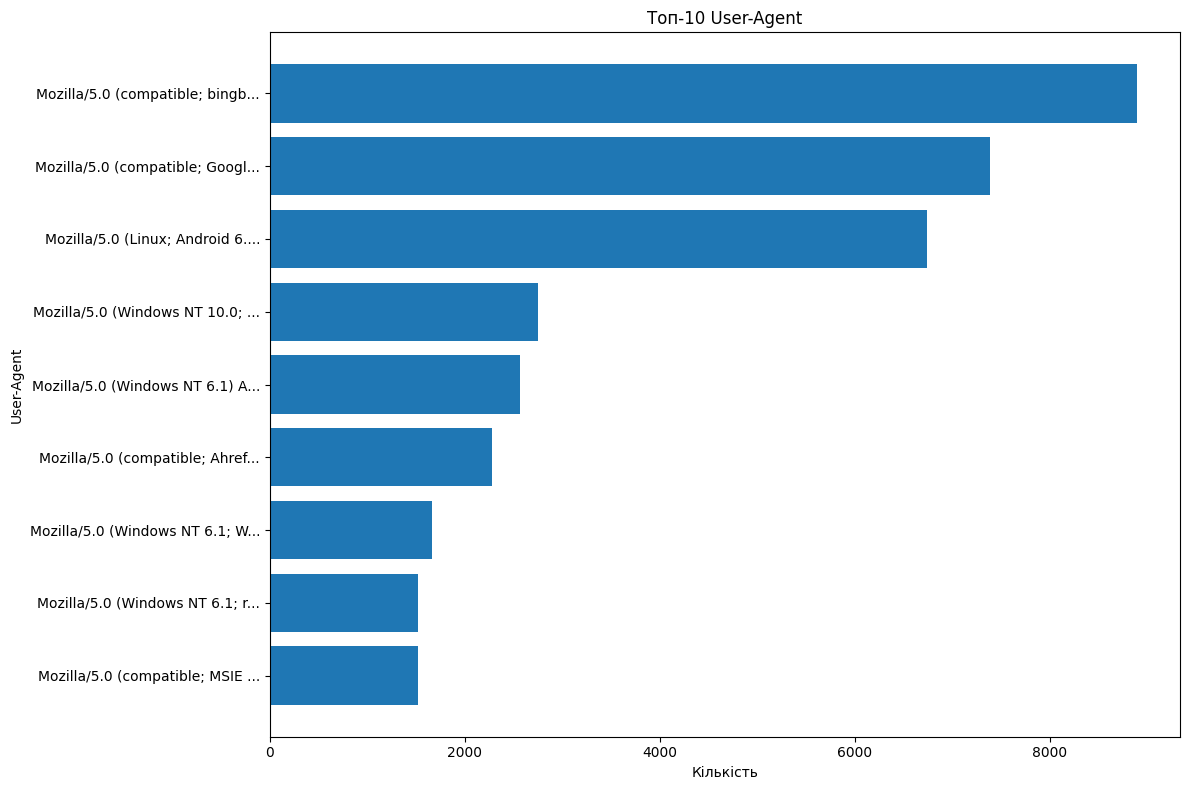

In [ ]:
# Ранжування користувачів за User-Agent
user_agent_counts = df['user_agent'].value_counts().reset_index(name='count')
user_agent_counts.columns = ['user_agent', 'count']

# Укорочення User-Agent для кращої читабельності
user_agent_counts['user_agent_short'] = user_agent_counts['user_agent'].apply(lambda x: (x[:30] + '...') if len(x) > 30 else x)

# Відображення таблиці
print(user_agent_counts)

# Побудова графіка
plt.figure(figsize=(12, 8))
top_10_user_agents = user_agent_counts.head(10)
plt.barh(top_10_user_agents['user_agent_short'], top_10_user_agents['count'])
plt.title('Топ-10 User-Agent')
plt.xlabel('Кількість')
plt.ylabel('User-Agent')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


               os  count
0         Android  50630
1           Other  46396
2       Windows 7  25478
3      Windows 10  13466
4           Linux  12226
5             iOS   6152
6           macOS   4728
7   Windows Vista   3040
8     Windows 8.1   2832
9      Windows XP   1336
10      Windows 8   1294


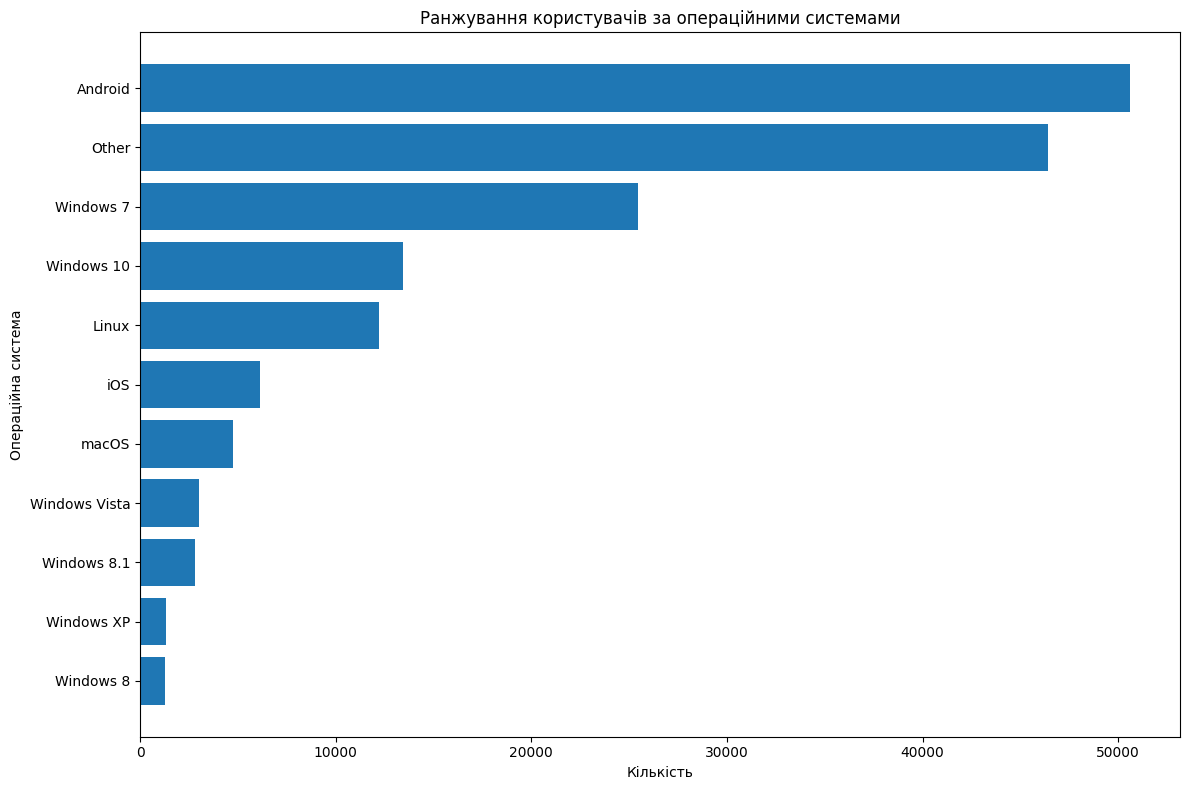

In [ ]:
# Функция для извлечения операционной системы из User-Agent
def extract_os(user_agent):
    os_patterns = [
        (r'Windows NT 10.0', 'Windows 10'),
        (r'Windows NT 6.3', 'Windows 8.1'),
        (r'Windows NT 6.2', 'Windows 8'),
        (r'Windows NT 6.1', 'Windows 7'),
        (r'Windows NT 6.0', 'Windows Vista'),
        (r'Windows NT 5.1', 'Windows XP'),
        (r'Macintosh; Intel Mac OS X', 'macOS'),
        (r'Linux; Android', 'Android'),
        (r'Linux', 'Linux'),
        (r'iPhone', 'iOS'),
        (r'iPad', 'iOS')
    ]
    for pattern, os_name in os_patterns:
        if re.search(pattern, user_agent):
            return os_name
    return 'Other'


with open(file_path, 'r') as file:
    chunk = []
    for line in file:
        parsed_entry = parse_log_entry(line)
        if parsed_entry:
            parsed_entry['os'] = extract_os(parsed_entry['user_agent'])  # Добавляем информацию об ОС
            chunk.append(parsed_entry)
        if len(chunk) >= chunk_size:
            parsed_entries.extend(chunk)
            chunk = []
    if chunk:
        parsed_entries.extend(chunk)

# Створення DataFrame зі спарсених даних
df = pd.DataFrame(parsed_entries)

# Витягнення дати з тимчасової мітки
df['date'] = df['timestamp'].dt.date

# Ранжування користувачів за операційними системами
os_counts = df['os'].value_counts().reset_index(name='count')
os_counts.columns = ['os', 'count']

# Відображення таблиці
print(os_counts)

# Побудова графіка
plt.figure(figsize=(12, 8))
plt.barh(os_counts['os'], os_counts['count'])
plt.title('Ранжування користувачів за операційними системами')
plt.xlabel('Кількість')
plt.ylabel('Операційна система')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
pip install geoip2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 1.3 MB/s eta 0:00:00


    Country  Unique Users
0        IR          2383
1        FR           411
2        US           271
3        HK            98
4        DE            79
5        NL            37
6        GB            33
7        CN            24
8        RU            15
9        CA            14
10       FI            13
11       AF             8
12  Unknown             7
13       JP             5
14       BR             4
15       SY             4
16       IQ             4
17       PL             3
18       TR             3
19       SI             3
20       IE             3
21       IL             3
22       DK             2
23       MA             2
24       LU             2
25       MY             2
26       AU             2
27       UA             2
28       VN             2
29       TH             1
30       AT             1
31       UZ             1
32       VE             1
33       SG             1
34       TW             1
35       CZ             1
36       RO             1
37       PK 

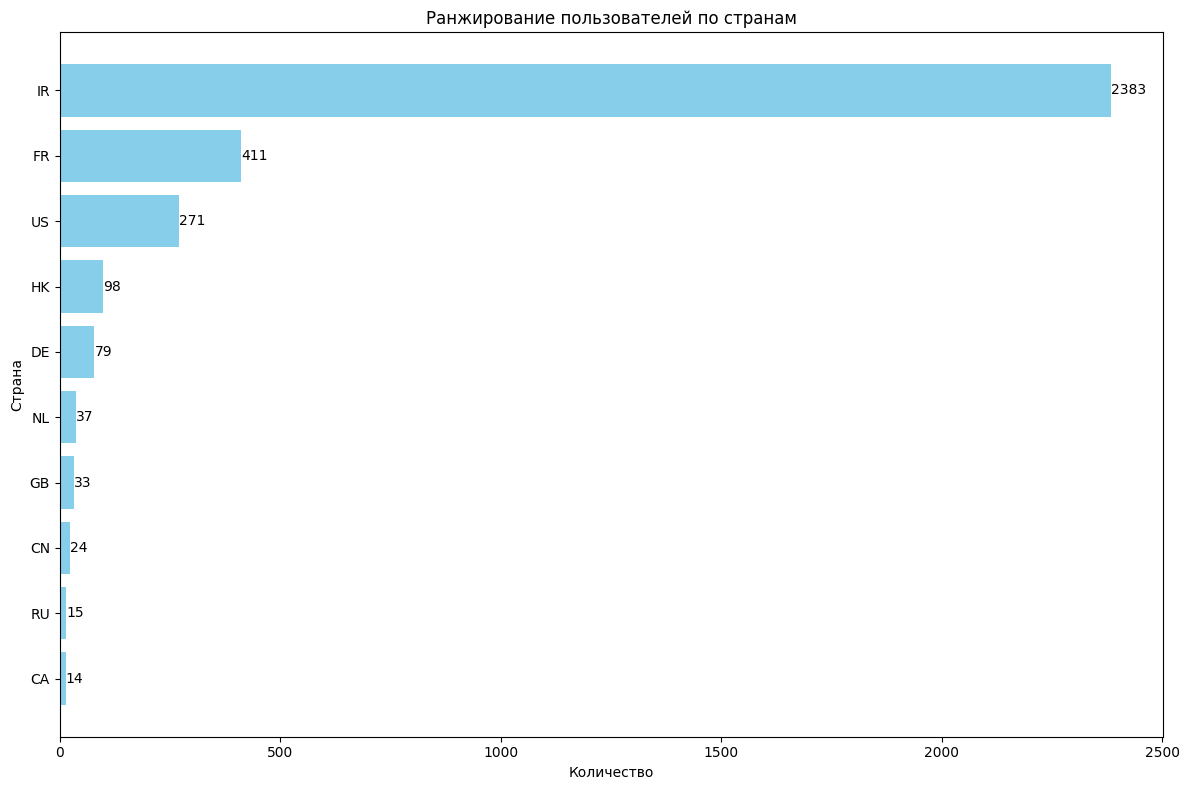

In [28]:

from datetime import datetime
import geoip2.database
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor


# Функция для извлечения страны из IP
def get_country(ip, reader):
    try:
        response = reader.country(ip)
        return response.country.iso_code if response.country.iso_code else 'Unknown'
    except Exception:
        return 'Unknown'

# Обработка одной строки журнала
def process_log_entry(entry, reader):
    parsed_entry = parse_log_entry(entry)
    if parsed_entry:
        parsed_entry['os'] = extract_os(parsed_entry['user_agent'])
        parsed_entry['country'] = get_country(parsed_entry['ip'], reader)
        return parsed_entry
    return None


geoip_db_path = 'GeoLite2-Country.mmdb'  # Замените на путь к вашей базе данных GeoLite2

# Чтение и обработка файла по частям с использованием многопоточности
parsed_entries = []
chunk_size = 10000  # Количество строк для обработки за раз

with geoip2.database.Reader(geoip_db_path) as reader:
    with open(file_path, 'r') as file:
        chunk = file.readlines(chunk_size)
        while chunk:
            with ThreadPoolExecutor() as executor:
                results = executor.map(lambda line: process_log_entry(line, reader), chunk)
                parsed_entries.extend([result for result in results if result])
            chunk = file.readlines(chunk_size)

# Создание DataFrame из обработанных данных
df = pd.DataFrame(parsed_entries)

# Извлечение даты из временной метки
df['date'] = df['timestamp'].dt.date



# Ранжирование пользователей по странам
country_ranking = df.groupby('country')['ip'].nunique().reset_index()
country_ranking.columns = ['Country', 'Unique Users']
country_ranking = country_ranking.sort_values(by='Unique Users', ascending=False).reset_index(drop=True)

# Отображение таблицы
print(country_ranking)

# Отображение топ-10 стран
top_10_countries = country_ranking.head(10)

# Построение графика
plt.figure(figsize=(12, 8))
bars = plt.barh(top_10_countries['Country'], top_10_countries['Unique Users'], color='skyblue')
plt.title('Ранжирование пользователей по странам')
plt.xlabel('Количество')
plt.ylabel('Страна')
plt.gca().invert_yaxis()

# Добавление значений на график
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width()}', va='center', ha='left')

plt.tight_layout()
plt.show()

                                          User-Agent  Unique Users
0  Mozilla/5.0 (compatible; Baiduspider/2.0; +htt...            17
1  Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...            16
2  Mozilla/5.0 (compatible; Googlebot/2.1; +http:...            16
3  Mozilla/5.0 (compatible; YandexBot/3.0; +http:...             8
4                                Googlebot-Image/1.0             7
5  Mozilla/5.0 (compatible; Yahoo! Slurp; http://...             2
6  Mozilla/5.0 (compatible; Exabot/3.0; +http://w...             1
7  Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Ge...             1


<ipython-input-27-0efb85464aa0>:55: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


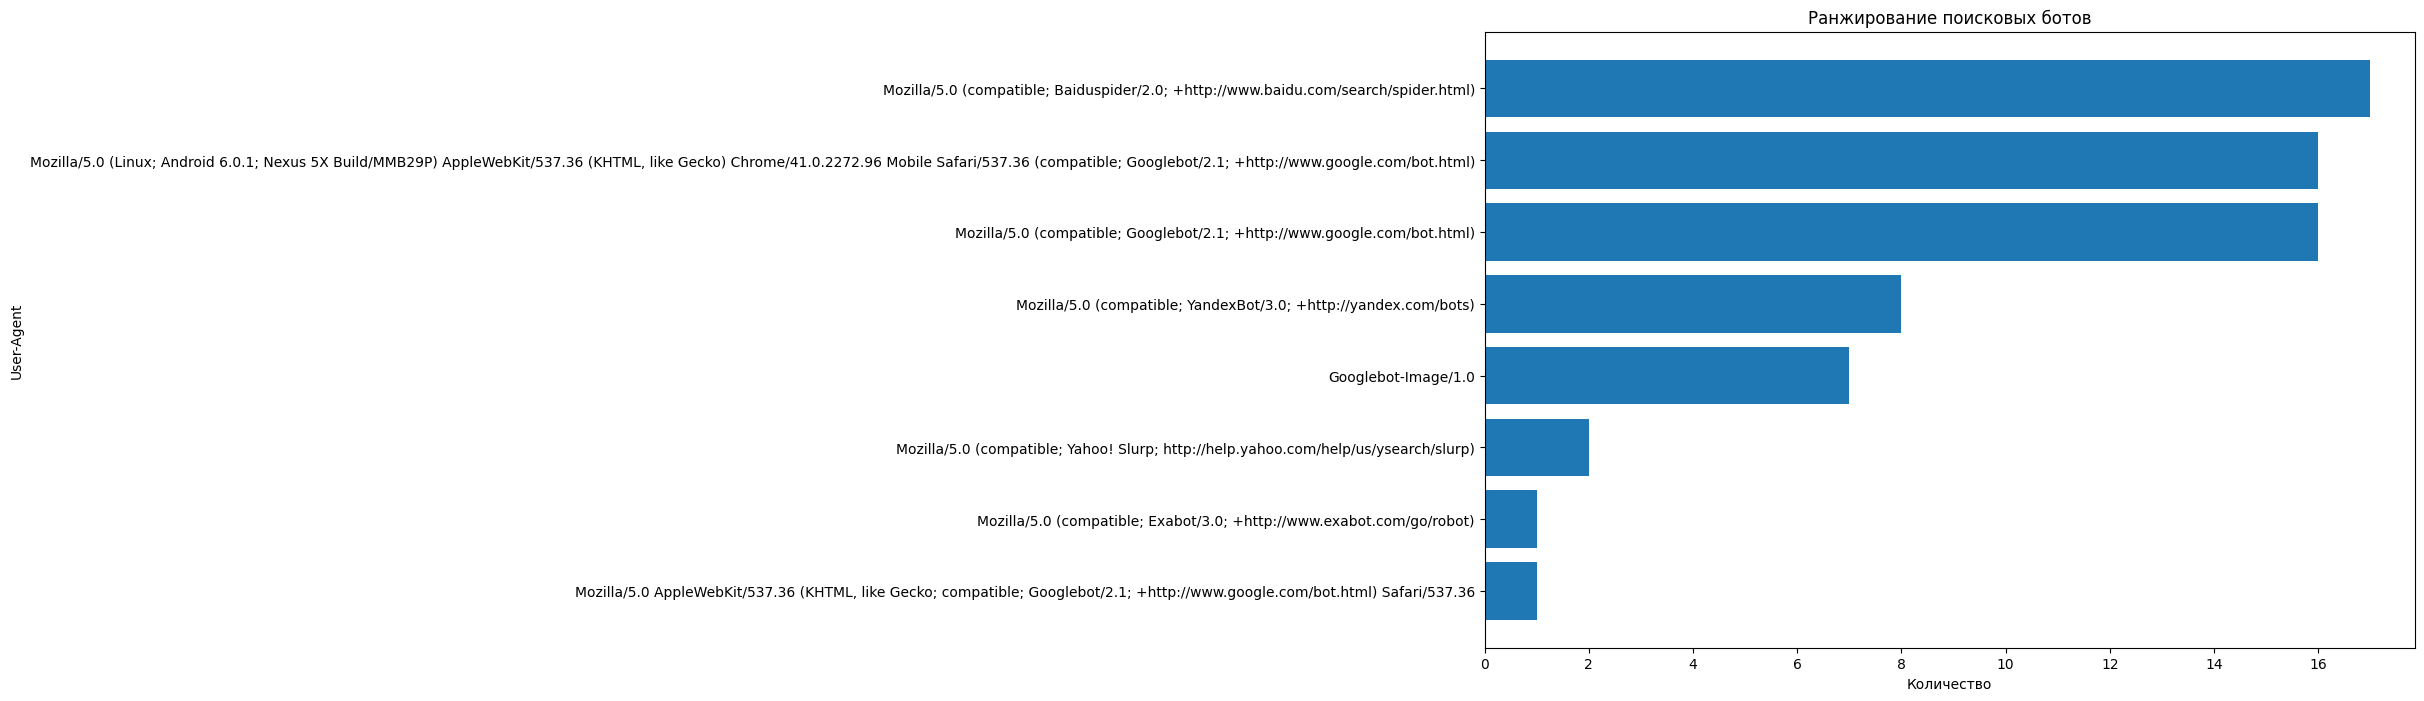

In [27]:
import re
import pandas as pd
import geoip2.database
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor


# Функция для определения, является ли User-Agent поисковым ботом
def is_search_bot(user_agent):
    bot_patterns = [
        'Googlebot', 'Bingbot', 'Slurp', 'DuckDuckBot', 'Baiduspider', 'YandexBot',
        'Sogou', 'Exabot', 'facebot', 'ia_archiver'
    ]
    for bot in bot_patterns:
        if bot in user_agent:
            return True
    return False

# Обработка одной строки журнала
def process_log_entry(entry):
    parsed_entry = parse_log_entry(entry)
    if parsed_entry:
        parsed_entry['is_bot'] = is_search_bot(parsed_entry['user_agent'])
        return parsed_entry
    return None


with open(file_path, 'r') as file:
    chunk = file.readlines(chunk_size)
    while chunk:
        with ThreadPoolExecutor() as executor:
            results = executor.map(process_log_entry, chunk)
            parsed_entries.extend([result for result in results if result])
        chunk = file.readlines(chunk_size)

# Создание DataFrame из обработанных данных
df = pd.DataFrame(parsed_entries)

# Выделение и ранжирование поисковых ботов
bot_df = df[df['is_bot']]
bot_ranking = bot_df.groupby('user_agent')['ip'].nunique().reset_index()
bot_ranking.columns = ['User-Agent', 'Unique Users']
bot_ranking = bot_ranking.sort_values(by='Unique Users', ascending=False).reset_index(drop=True)

# Отображение таблицы с ботами
print(bot_ranking)

# Построение графика для ботов
plt.figure(figsize=(12, 8))
plt.barh(bot_ranking['User-Agent'], bot_ranking['Unique Users'])
plt.title('Ранжирование поисковых ботов')
plt.xlabel('Количество')
plt.ylabel('User-Agent')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Found 2338 anomalies


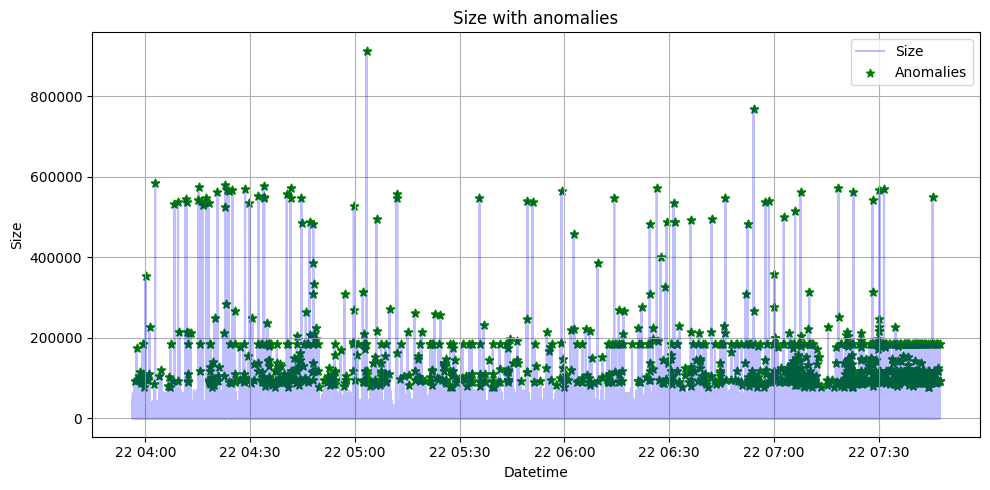

In [38]:
# Обработка одной строки журнала
def process_log_entry(entry):
    parsed_entry = parse_log_entry(entry)
    if parsed_entry:
        return parsed_entry
    return None

with open(file_path, 'r') as file:
    chunk = file.readlines(chunk_size)
    while chunk:
        with ThreadPoolExecutor() as executor:
            results = executor.map(process_log_entry, chunk)
            parsed_entries.extend([result for result in results if result])
        chunk = file.readlines(chunk_size)

# Создание DataFrame из обработанных данных
df = pd.DataFrame(parsed_entries)

# Конвертация timestamp в datetime и разбиение на дату и время
df['datetime'] = pd.to_datetime(df['timestamp'])
df['date'] = df['datetime'].dt.date
df['time'] = df['datetime'].dt.time

# Конвертация столбца 'size' в числовой тип
df['size'] = pd.to_numeric(df['size'], errors='coerce')

# Вычисление квартилей и межквартильного размаха
Q1 = df['size'].quantile(0.25)
Q3 = df['size'].quantile(0.75)
IQR = Q3 - Q1

# Определение границ для аномалий
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Определение аномалий
anomalies = df[(df['size'] < lower_bound) | (df['size'] > upper_bound)]
print(f"Found {len(anomalies)} anomalies")

# Построение графика с аномалиями
plt.figure(figsize=(10, 5))
plt.plot(df['datetime'], df['size'], label='Size', color='blue', alpha=0.25)
plt.scatter(anomalies['datetime'], anomalies['size'], color='green', label='Anomalies', marker='*')
plt.title('Size with anomalies')
plt.xlabel('Datetime')
plt.ylabel('Size')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()
